In [87]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import norm,spearmanr
from collections import defaultdict
import seaborn as sns
import pickle
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
data = pd.read_csv('./../data/round.csv')

In [5]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [6]:
data.shape

(254628, 12)

In [7]:
data.tail()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
254623,2016,470,27,689,35545,"Barber, Blayne",4,12:30,75,T41,44.0,0.445153
254624,2016,470,27,689,36689,"Koepka, Brooks",4,08:20,73,T70,71.5,0.725765
254625,2016,470,27,689,37189,"Varner III, Harold",4,10:30,75,T60,61.5,0.623724
254626,2016,470,27,689,40026,"Berger, Daniel",4,08:40,74,T70,71.5,0.725765
254627,2016,470,27,689,40058,"Blair, Zac",4,07:40,73,T74,75.0,0.761480


In [8]:
with open('./../PickleFiles/num_to_ind_round.pkl','r') as pickleFile:
    num_to_inds = pickle.load(pickleFile)

In [9]:
data.insert(5,'Player_Index',[num_to_inds[num] for num in data.Player_Number])

In [10]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [11]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)
n_tournaments = len(data.groupby(['Tournament_Year','Permanent_Tournament_#']))

In [12]:
print n_players,n_rounds,n_tournaments

2594 2805 624


In [13]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((loader['data'],loader['indices'],loader['indptr']),shape = loader['shape'])

In [14]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [52]:
range(0,1)

[0]

In [114]:
def inflate(tournament_group,BETA,window_size=28):
    A = bmat([[bmat([[load_sparse_csc('./../rounds/%dA.npz' % i)*my_norm(i-k,BETA)] 
                 for k in range(max(0,tournament_group-window_size+1),tournament_group+1)],format='csc') 
              for i in range(max(0,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    
    G = bmat([[bmat([[load_sparse_csc('./../rounds/%dG.npz' % i)*my_norm(i-k,BETA)] 
                 for k in range(max(0,tournament_group-window_size+1),tournament_group+1)],format='csc') 
              for i in range(max(0,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    
    return (A,G)

In [115]:
def alpha(A,a):
    A.data[A.data<1e-6] = 0
    A.data[np.isnan(A.data)]=0
    w,v = eigs(A,k=1,which='LM')
    if w.imag>0:
        print w
    return a/w[0].real

In [116]:
def solve(mat,mat_1,a,min_reps,x_guess=None,x_guess1=None):
    mat.data[mat_1.data<1e-6] = 0
    mat_1.data[mat_1.data<1e-6] = 0
    mat.data[np.isnan(mat.data)] = 0
    mat_1.data[np.isnan(mat_1.data)] = 0
    
    alpha_ = alpha(mat,a)
    S = eye(mat.shape[0],format='csc')-alpha_*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    
    S = eye(mat_1.shape[0],format='csc')-alpha_*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    
    w_a[w_g<min_reps]=0
    solve.w_a = w_a
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [ ]:
ranks,reps = [],[]
BETA = 6
a = .8
bin_size = 4
window_size = 28
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
for tournament_group in range(n_tournament_groups):
    A,G = inflate(tournament_group,BETA)
    if tournament_group==0:
        res = solve(A,G,a,1)
        ranks.append(res[0])
        reps.append(res[1])
        print 'Tournament Group %d done' % tournament_group
    else:
        w_a_approx = np.append(solve.w_a[0 if tournament_group<window_size else n_players:],solve.w_a[-n_players:])
        w_g_approx = np.append(solve.w_g[0 if tournament_group<window_size else n_players:],solve.w_g[-n_players:])
        res = solve(A,G,a,1,w_a_approx,w_g_approx)
        ranks.append(res[0])
        reps.append(res[1])
        print 'Tournament Group %d done' % tournament_group

Tournament Group 0 done
Tournament Group 1 done
Tournament Group 2 done
Tournament Group 3 done
Tournament Group 4 done
Tournament Group 5 done
Tournament Group 6 done
Tournament Group 7 done
Tournament Group 8 done
Tournament Group 9 done
Tournament Group 10 done
Tournament Group 11 done
Tournament Group 12 done
Tournament Group 13 done
Tournament Group 14 done
Tournament Group 15 done
Tournament Group 16 done
Tournament Group 17 done
Tournament Group 18 done
Tournament Group 19 done
Tournament Group 20 done
Tournament Group 21 done
Tournament Group 22 done
Tournament Group 23 done
Tournament Group 24 done
Tournament Group 25 done
Tournament Group 26 done
Tournament Group 27 done
Tournament Group 28 done
Tournament Group 29 done
Tournament Group 30 done
Tournament Group 31 done
Tournament Group 32 done
Tournament Group 33 done
Tournament Group 34 done
Tournament Group 35 done
Tournament Group 36 done
Tournament Group 37 done
Tournament Group 38 done
Tournament Group 39 done
Tournament

KeyboardInterrupt: 

In [89]:
A.shape

(59662, 59662)

In [20]:
# with open('round_level_ranks.pkl','w') as pickleFile:
#     pickle.dump(ranks,pickleFile)

# with open('round_level_reps.pkl','w') as pickleFile:
#     pickle.dump(reps,pickleFile)

In [97]:
tournament_groups = defaultdict(list)
tournaments = set()
for (year,tourn),df in data.groupby(['Tournament_Year','Permanent_Tournament_#'],sort=False):
    tournaments.add((year,tourn))
    tournament_group = (len(tournaments)-1)/bin_size
    tournament_groups[tournament_group].append((year,tourn))

In [100]:
master_df = pd.DataFrame({'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Field_Strength':[],
                          'Finishing_Pct':[],'Rating':[],'Reps':[],'Pct_Reps':[]})
for j in range(len(ranks)):
    df = pd.DataFrame({'player_ind':range(n_players),
                       'rank':ranks[j],
                       'reps':reps[j]}).dropna()
    pct_reps = pd.Series(df.reps[df.reps!=0]).rank(pct=True)
    df.insert(len(df.columns),'pct_reps',[0]*len(df))
    df.ix[df.reps!=0,'pct_reps'] = pct_reps
    rank_dict,reps_dict,pct_reps_dict = df['rank'].to_dict(),df['reps'].to_dict(),df['pct_reps'].to_dict()
    years = [i[0] for i in tournament_groups[j+1]]
    t_ids = [i[1] for i in tournament_groups[j+1]]
    df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    df3['Rating'] = df3['Player_Index'].map(rank_dict)
    df3['Reps'] = df3['Player_Index'].map(reps_dict)
    df3['Pct_Reps'] = df3['Player_Index'].map(pct_reps_dict)
    df3 = df3[df3.Rating!=0].dropna()
    tourn_strength_dict = df3.groupby('Permanent_Tournament_#')['Rating'].mean().to_dict()
    df3['Field_Strength'] = df3['Permanent_Tournament_#'].map(tourn_strength_dict)
    master_df = pd.concat([master_df,df3])

# master_df = master_df.dropna()
# master_df = master_df[master_df.Rating!=0]

In [101]:
(master_df.Rating!=0).sum()==len(master_df)

True

In [102]:
master_df.head(5)

,Course_#,Field_Strength,Finishing_Pct,Pct_Reps,Permanent_Tournament_#,Player_Index,Rating,Reps
0,4,1.000529,0.279867,0.062201,4,0,1.035082,735.703158
1,104,1.000529,0.279867,0.062201,4,0,1.035082,735.703158
2,500,1.005632,0.116898,0.062201,7,0,1.035082,735.703158
3,101,0.998481,0.277412,1.000000,1,1,1.027284,5892.487407
4,500,1.005632,0.116898,1.000000,7,1,1.027284,5892.487407


In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

ols = LinearRegression()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [103]:
spearmanr(master_df.Rating,master_df.Finishing_Pct)[0]

-0.33235153091293884

In [104]:
np.corrcoef(master_df.Rating,master_df.Finishing_Pct)

array([[ 1.        , -0.33426561],
       [-0.33426561,  1.        ]])

In [105]:
len(master_df)

14413

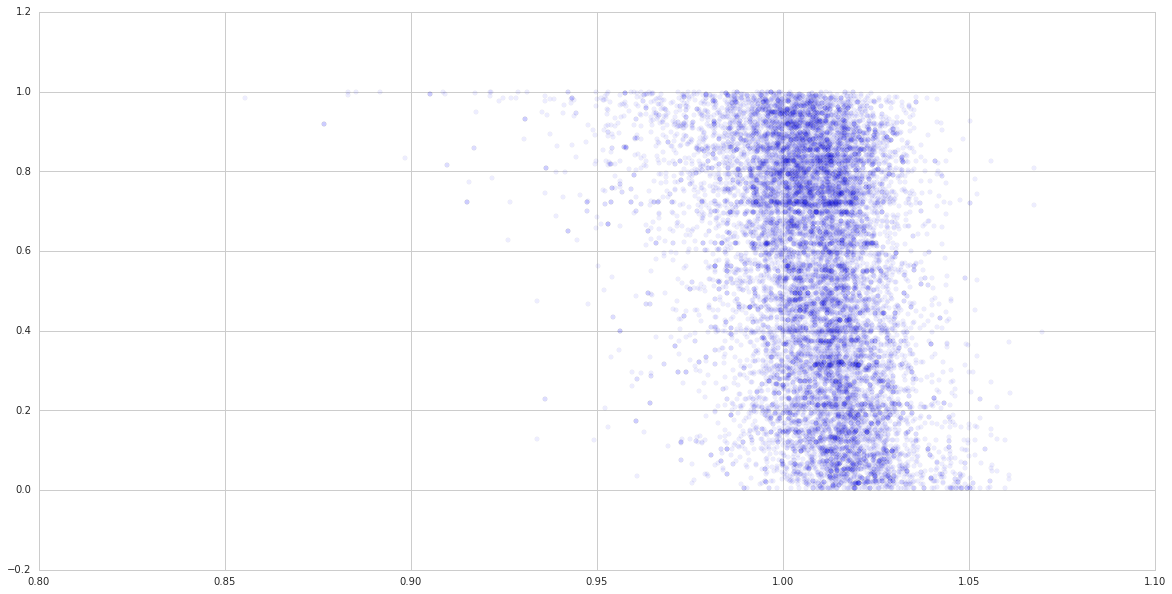

In [106]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(master_df.Rating,master_df.Finishing_Pct,alpha=.07);

In [107]:
X,y = master_df.Rating.values-master_df.Field_Strength.values,master_df.Finishing_Pct.values

In [110]:
ols.fit(X[:,None],y)
print ols.intercept_,ols.coef_[0]

0.5552764324 -6.40740597775


In [111]:
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
print ols.intercept_,ols.coef_[0]

0.560344448586 -8.72457260375


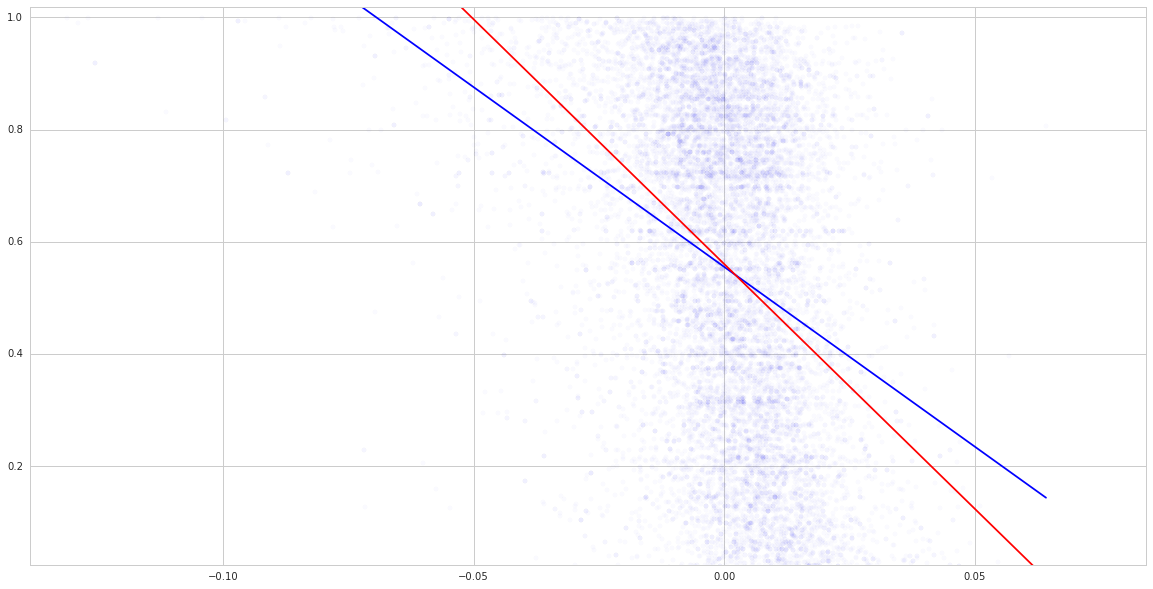

In [112]:
ols.fit(X[:,None],y)
predictions_u = ols.predict(np.sort(X)[:,None])
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(X,y,alpha=.02)
plt.plot(np.sort(X),predictions_u,c='b')
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
predictions_w = ols.predict(np.sort(X)[:,None])
plt.plot(np.sort(X),predictions_w,c='r')
plt.xlim(X.min()+.02,X.max()+.02);
plt.ylim(y.min()+.02,y.max()+.02);

In [26]:
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
residuals = ols.predict(X[:,None]) - y
np.corrcoef(residuals,master_df.Reps)

array([[ 1.        , -0.01667141],
       [-0.01667141,  1.        ]])

In [90]:
squared_residuals = (ols.predict(X[:,None]) - y)**2
weighted_squared_residuals = squared_residuals * master_df.Reps.values / master_df.Reps.sum()
RMWSR = np.mean(weighted_squared_residuals)**.5

In [93]:
RMWSR

0.0021116823889155006

In [100]:
kfold = KFold(len(y),n_folds=10,shuffle=True)
scores = []
for train,test in kfold:
    ols.fit(X[train,None],y[train],sample_weight=master_df.Reps.values[train])
    predictions = ols.predict(X[test,None])
    squared_residuals = (predictions - y[test])**2
    weighted_squared_residuals = squared_residuals * master_df.Reps.values[test] / master_df.Reps.values[test].sum()
    RMWSR = np.mean(weighted_squared_residuals)**.5
    scores.append(RMWSR)
print np.mean(scores),np.std(scores),np.mean(scores)+np.std(scores)/10**.5

0.00667804590585 9.66755461517e-05 0.00670861739784


In [33]:
y = (ols.predict(X[:,None]) - y)**2
X = master_df.Reps.values

In [37]:
X = sm.add_constant(X)

In [34]:
ols.fit(X[:,None],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
w = ols.predict(X[:,None])

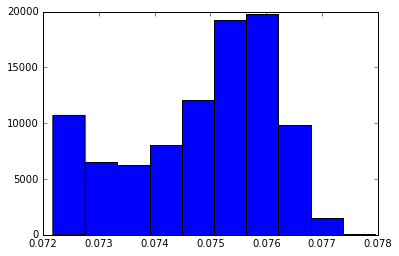

In [38]:
plt.hist(w);

In [39]:
pd.Series(master_df.Field_Strength).describe()

count    94064.000000
mean         1.002345
std          0.004796
min          0.987007
25%          0.999344
50%          1.001648
75%          1.005182
max          1.024925
Name: Field_Strength, dtype: float64

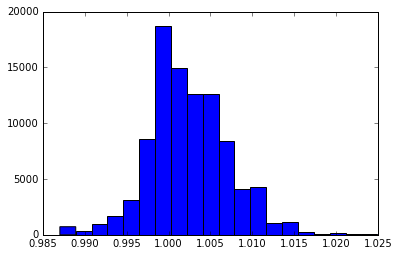

In [40]:
plt.hist(master_df.Field_Strength.values,20);

In [ ]:
# model = sm.WLS(y, X, 1/w)
results = model.fit()
print(results.summary())

In [89]:
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X)

In [52]:
cross_val_score(ols,X,y,cv=10).mean()

NameError: name 'cross_val_score' is not defined

In [135]:
X.shape

(13645, 3)

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


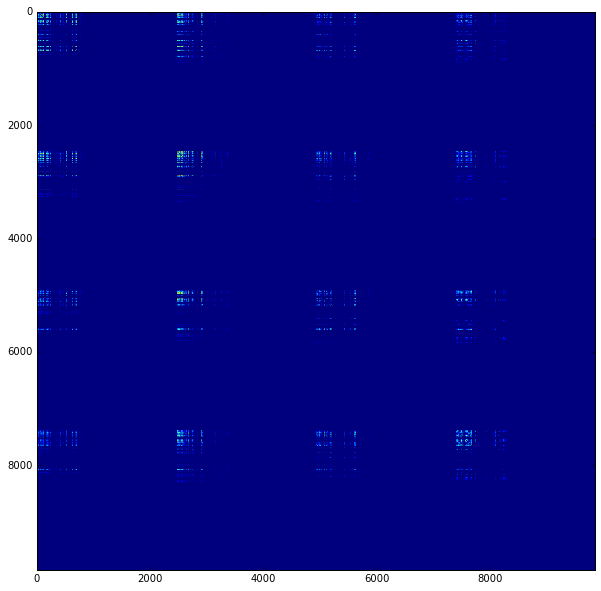

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());

In [158]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[15]}).sort_values('rank',ascending=False).dropna()

,player_ind,player_name,rank
13,13,"Singh, Vijay",1.041156
277,277,"Woods, Tiger",1.040426
12,12,"Els, Ernie",1.036093
341,341,"Harrington, Padraig",1.035531
572,572,"Ho, S.K.",1.035140
180,180,"Weir, Mike",1.031608
532,532,"Ruiz, Marco",1.029694
162,162,"Mickelson, Phil",1.029583
27,27,"Goosen, Retief",1.029180
331,331,"Scott, Adam",1.028445


In [11]:
from collections import defaultdict

In [34]:
current_group = 0
tournament_groups=[set()]
tournaments = set()
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournaments.add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournament_group = (len(tournaments)-1)/bin_size
    if tournament_group>current_group:
        current_group = tournament_group
        tournament_groups.append(set())
        rounds_to_inflate = []
    tournament_groups[current_group].add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))

In [30]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [31]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [32]:
# inds_to_plot = [names_to_ind['Mickelson, Phil'],names_to_ind['Woods, Tiger'],
#                 names_to_ind['S, Vijay'],names_to_ind['Donald, Luke']]
inds_to_plot = [names_to_ind['Woods, Tiger']]
#names_to_ind['Woods, Tiger'],names_to_ind['Day, Jason'],names_to_ind['Donald, Luke']
#names_to_ind['Stricker, Steve'],names_to_ind['Spieth, Jordan'],

In [25]:
import pickle
with open('round_ranks.pkl','r') as pickleFile:
    ranks = pickle.load(pickleFile)

In [40]:
from numpy import trapz

In [42]:
ax.xaxis.get_major_ticks()

In [47]:
year_inds

[(2003, 0),
 (2004, 12),
 (2005, 23),
 (2006, 35),
 (2007, 46),
 (2008, 57),
 (2009, 69),
 (2010, 80),
 (2011, 92),
 (2012, 103),
 (2013, 113),
 (2014, 123),
 (2015, 134),
 (2016, 145)]

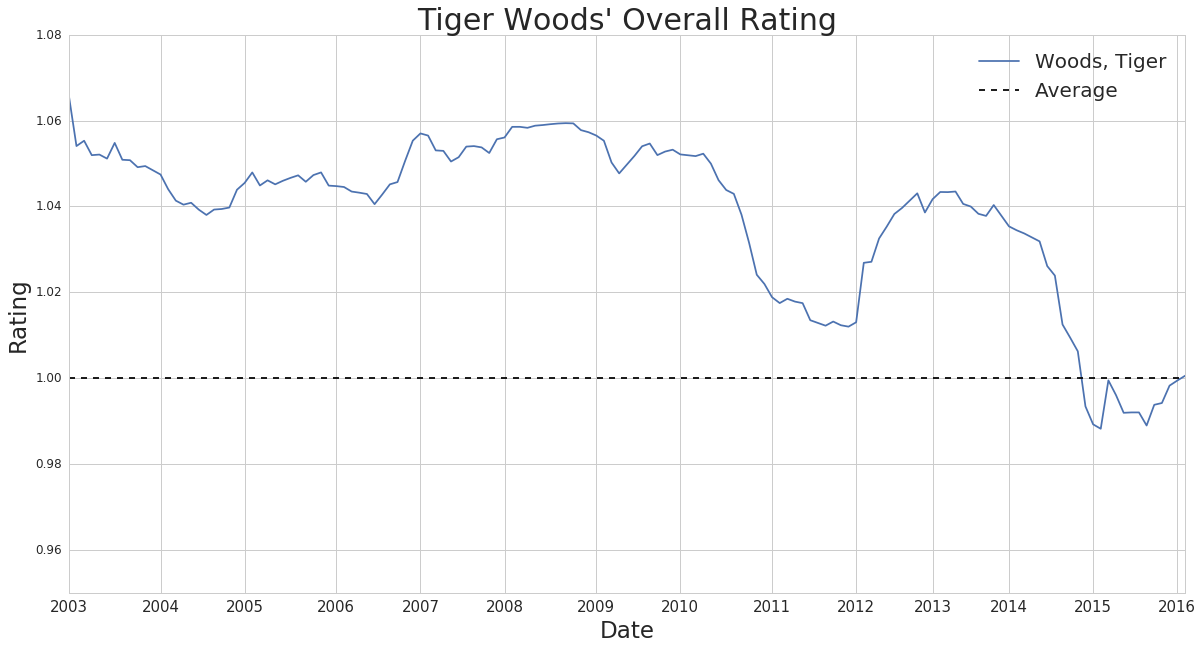

In [76]:
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    y = np.array([ranks[i][j] for i in range(len(ranks))])
    y = y[np.logical_not(np.isnan(y))]
    area = trapz(y, dx=5)
    plt.plot([ranks[i][j] for i in range(len(ranks))],label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
plt.plot((0,146),(1,1),ls='--',c='black',label='Average')
plt.legend(prop={'size':20});
plt.ylim(.95,1.08);
plt.xlim(0,146);
ax.set_title("Tiger Woods' Overall Rating",size=30)
ax.set_xlabel('Date',size=23)
ax.set_ylabel('Rating',size=23)
plt.savefig('TigerGeneral.png',bbox_inches='tight',dpi=200)

In [36]:
year_inds = [max([map(int,[i.split(',')[0] for i in j])]) for j in tournament_groups]

In [37]:
from collections import Counter
year_inds = [Counter(i) for i in year_inds]

In [38]:
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]

In [39]:
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]